In [80]:
import os
import glob
import re
import numpy as np
import numpy.fft as fft
import mne
import matplotlib.pyplot as plt
from scipy import stats, signal
from numpy import save, load
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree



### read dataset X and Y

In [81]:
subject_id=1
base_path = "features_notwelch/"
# edf_file_names = sorted(glob.glob(os.path.join(base_path, "data_chb01/*.npy".format(subject_id))))
# files=len(edf_file_names)
X=load('features_notwelch/data_chb01/features_{}_00.npy'.format(subject_id))
y=load('features_notwelch/data_chb01/targets_{}_00.npy'.format(subject_id))
for subject_id in (1,3,6,7,8):
    edf_file_names = sorted(glob.glob(os.path.join(base_path, "data_chb{:02d}/*.npy".format(subject_id))))
    files=len(edf_file_names)
    print(files)
    print(X.shape)
    start=0
    if subject_id==1:
        start=1
    for fileno in range(start, files//2):
        X=np.concatenate((X, load('features_notwelch/data_chb{:02d}/features_{}_{:02d}.npy'.format(subject_id, subject_id, fileno))))
        y=np.concatenate((y, load('features_notwelch/data_chb{:02d}/targets_{}_{:02d}.npy'.format(subject_id,subject_id, fileno))))


84
(408, 208)
76
(14577, 208)
36
(28145, 208)
38
(52073, 208)
40
(76155, 208)


In [82]:
X_shape, y_shape = X.shape, y.shape
print(X_shape, y_shape)

(83290, 208) (83290,)


In [184]:
def generate_column_names():
    channel_order= {'FP1-F7':0, 'F7-T7':1, 'T7-P7':2, 'P7-O1':3, 'FP1-F3':4, 'F3-C3':5, 'C3-P3':6, 'P3-O1':7, 'FP2-F4':8, 'F4-C4':9, 'C4-P4':10, 'P4-O2':11, 'FP2-F8':12, 'F8-T8':13, 'T8-P8-0':14, 'P8-O2':15, 'FZ-CZ':16, 'CZ-PZ':17, 'P7-T7':18, 'T7-FT9':19, 'FT9-FT10':20, 'FT10-T8':21 ,'T8-P8-1':22 }
    col_names=[]
    for ch in channel_order:
        # print(ch)
        for i in range(0,9):
            col_names.append(str(ch)+'-'+str(i))
    # col_names.append('rms')
    # col_names.append('sum')
    col_names.append('patient')
    # print(col_names.shape)
    return col_names


In [185]:
df=pd.DataFrame(data=X, columns=generate_column_names())
# df=pd.read_csv('df2.csv')
# df['patient']=1
# df.at[14577:27187,'patient',]=2
# df.at[27187:40755, 'patient']=3
# df.at[40755:97783, 'patient']=4
# df.at[97783:, 'patient']=5

df['target']=y
print(df.shape)
df=df.dropna()
print(df.shape)
df.reset_index(drop=True, inplace=True)
df

(83290, 209)
(83290, 209)


,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,T8-P8-1-1,T8-P8-1-2,T8-P8-1-3,T8-P8-1-4,T8-P8-1-5,T8-P8-1-6,T8-P8-1-7,T8-P8-1-8,patient,target
0,0.009253,0.205576,0.015386,0.013003,0.353573,0.068100,0.261663,0.048393,13087.628906,0.009094,...,0.160299,0.006780,0.013950,0.344800,0.081632,0.294163,0.059692,2853.293701,1.0,0
1,0.010184,0.198871,0.017687,0.014204,0.371332,0.078176,0.244087,0.050380,13272.797852,0.009179,...,0.166040,0.009536,0.017124,0.360151,0.080480,0.282719,0.057230,2595.387695,1.0,0
2,0.013337,0.209899,0.024952,0.019939,0.382135,0.072422,0.219988,0.053930,9027.048828,0.010076,...,0.128410,0.010422,0.017145,0.405914,0.107520,0.246479,0.072111,2669.577881,1.0,0
3,0.014367,0.214465,0.024949,0.024575,0.367699,0.068725,0.233418,0.046182,6688.242676,0.017899,...,0.138748,0.010597,0.014635,0.405534,0.109894,0.233375,0.072846,2570.697998,1.0,0
4,0.024251,0.179508,0.064263,0.053937,0.377249,0.069827,0.200093,0.030606,4267.430176,0.043423,...,0.160317,0.014761,0.022323,0.309459,0.085600,0.301347,0.069259,1922.287476,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83285,0.008805,0.162759,0.021875,0.016082,0.349363,0.080733,0.279748,0.066814,14735.153320,0.004093,...,0.209121,0.008912,0.010706,0.424271,0.065908,0.208240,0.045127,26926.115234,8.0,0
83286,0.017645,0.218688,0.020033,0.019581,0.390985,0.076732,0.217819,0.045547,6259.095703,0.003820,...,0.202268,0.006331,0.007070,0.421968,0.061125,0.217734,0.052048,43083.664062,8.0,0
83287,0.016607,0.104798,0.030455,0.021936,0.281037,0.185331,0.306219,0.074334,7056.773926,0.003916,...,0.209323,0.004378,0.005458,0.428714,0.052781,0.217020,0.056849,34002.648438,8.0,0
83288,0.014434,0.072497,0.041453,0.022231,0.244569,0.183943,0.329688,0.089199,7828.537109,0.005187,...,0.238687,0.006064,0.007115,0.425626,0.044030,0.216710,0.049417,21102.750000,8.0,0


In [186]:
df['seizure_number']=0

In [187]:
seizure_number=1
for i in range(1, len(df)):
    # if df.iloc[i]['target']==2 and df.iloc[i-1]['target']==2:
    #     df.iloc[i]['seizure_number']=df.iloc[i-1]['seizure_number']
    if df.iloc[i]['target']==2:
        df.at[i,'seizure_number']=seizure_number
    if (df.iloc[i]['target']!=2 and df.iloc[i-1]['target']==2 ):
        seizure_number+=1
# df.to_csv(r'df.csv')


In [188]:
# test_df=pd.DataFrame()
# for patient in pd.unique(df['patient']):
#     # patdf=df[df[207]==patient]
#     last_seizure=max(df[df['patient']==patient]['seizure_number'])
#     test_df = test_df.append(df[(df['patient']==patient) & (df['seizure_number']==last_seizure)], ignore_index=False)
# test_df

In [189]:
test_df=pd.DataFrame()
for patient in pd.unique(df['patient']):
    # patdf=df[df[207]==patient]
    last_seizure=max(df[df['patient']==patient]['seizure_number'])
    test_df = test_df.append(df[(df['patient']==patient) & (df['seizure_number']==last_seizure)], ignore_index=False)
test_df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,T8-P8-1-2,T8-P8-1-3,T8-P8-1-4,T8-P8-1-5,T8-P8-1-6,T8-P8-1-7,T8-P8-1-8,patient,target,seizure_number
9049,0.487906,0.294157,0.062645,0.243455,0.061901,0.003636,0.013767,0.003427,733.779602,0.385181,...,0.066628,0.112517,0.115718,0.304856,0.541955,0.017563,1923.753174,1.0,2,7
9050,0.492928,0.287013,0.072026,0.238879,0.060910,0.002932,0.012587,0.004014,711.672302,0.415166,...,0.068790,0.102843,0.090541,0.174525,0.623085,0.014286,2015.595825,1.0,2,7
9051,0.406936,0.237590,0.078928,0.220020,0.104659,0.004607,0.020451,0.006975,398.291138,0.365368,...,0.043970,0.070681,0.184607,0.131209,0.573714,0.013855,1690.714233,1.0,2,7
9052,0.377607,0.232304,0.089268,0.232302,0.118813,0.004778,0.024522,0.006443,364.721436,0.288228,...,0.031371,0.090012,0.247403,0.039392,0.497692,0.018659,1452.021973,1.0,2,7
9053,0.464701,0.204894,0.068319,0.203080,0.098251,0.004644,0.023169,0.005235,448.785583,0.327284,...,0.033024,0.077684,0.193197,0.135930,0.552392,0.023126,1480.842529,1.0,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81703,0.017256,0.209403,0.070842,0.039287,0.403884,0.056886,0.163587,0.047513,5765.841309,0.003769,...,0.001737,0.002591,0.474666,0.046714,0.148483,0.035165,46012.910156,8.0,2,32
81704,0.039424,0.121447,0.025973,0.041864,0.234295,0.086562,0.322091,0.114735,22553.650391,0.005153,...,0.002619,0.003396,0.452980,0.049848,0.168879,0.045196,49227.437500,8.0,2,32
81705,0.032944,0.099493,0.029003,0.037000,0.186723,0.090095,0.391559,0.108849,27790.220703,0.004798,...,0.002605,0.003291,0.444350,0.050071,0.169784,0.040584,47833.875000,8.0,2,32
81706,0.006416,0.075112,0.029427,0.012989,0.182027,0.084335,0.456701,0.114316,24023.494141,0.004408,...,0.002769,0.003717,0.464063,0.049957,0.155699,0.030718,35271.335938,8.0,2,32


In [190]:
test_df['target'].max()

2

In [191]:
df = df[df.index.isin(test_df.index) == False]

In [192]:
test_df.shape

(290, 210)

### train test split

In [193]:
df_interictal=df[df['target']==0]
df_interictal=df_interictal.sample(frac=0.2)
df_preictal=df[df['target']==2]
interictal_shape, preictal_shape = df_interictal.shape, df_preictal.shape
interictal_shape= df_interictal.shape

print(df_interictal.shape,  df_preictal.shape)


(14004, 210) (1468, 210)


In [194]:
X_interictal=np.array(df_interictal[df.columns[:-2]]).astype('float32')
y_interictal=np.array(df_interictal['target']).astype('float32')
X_preictal_train  =np.array(df_preictal[df.columns[:-2]]).astype('float32')
y_preictal_train  =np.array(df_preictal['target']).astype('float32')

In [195]:
print(X_interictal.shape)
print(y_interictal.shape)
print(X_preictal_train.shape)
print(y_preictal_train.shape)

(14004, 208)
(14004,)
(1468, 208)
(1468,)


### train test split

In [196]:
from sklearn.model_selection import train_test_split


In [197]:
X_interictal_train, X_interictal_test, y_interictal_train, y_interictal_test =train_test_split(X_interictal,y_interictal,test_size=0.1, random_state=42)
# X_preictal_train, X_preictal_test, y_preictal_train, y_preictal_test=train_test_split(X_preictal, y_preictal,test_size=0.1, random_state=42)

In [198]:
interictal_test_df=pd.DataFrame(data=X_interictal_test)
interictal_test_df['target']=y_interictal_test
interictal_test_df
# test_df=test_df.append(interictal_test_df, ignore_index=True)
test_df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,T8-P8-1-2,T8-P8-1-3,T8-P8-1-4,T8-P8-1-5,T8-P8-1-6,T8-P8-1-7,T8-P8-1-8,patient,target,seizure_number
9049,0.487906,0.294157,0.062645,0.243455,0.061901,0.003636,0.013767,0.003427,733.779602,0.385181,...,0.066628,0.112517,0.115718,0.304856,0.541955,0.017563,1923.753174,1.0,2,7
9050,0.492928,0.287013,0.072026,0.238879,0.060910,0.002932,0.012587,0.004014,711.672302,0.415166,...,0.068790,0.102843,0.090541,0.174525,0.623085,0.014286,2015.595825,1.0,2,7
9051,0.406936,0.237590,0.078928,0.220020,0.104659,0.004607,0.020451,0.006975,398.291138,0.365368,...,0.043970,0.070681,0.184607,0.131209,0.573714,0.013855,1690.714233,1.0,2,7
9052,0.377607,0.232304,0.089268,0.232302,0.118813,0.004778,0.024522,0.006443,364.721436,0.288228,...,0.031371,0.090012,0.247403,0.039392,0.497692,0.018659,1452.021973,1.0,2,7
9053,0.464701,0.204894,0.068319,0.203080,0.098251,0.004644,0.023169,0.005235,448.785583,0.327284,...,0.033024,0.077684,0.193197,0.135930,0.552392,0.023126,1480.842529,1.0,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81703,0.017256,0.209403,0.070842,0.039287,0.403884,0.056886,0.163587,0.047513,5765.841309,0.003769,...,0.001737,0.002591,0.474666,0.046714,0.148483,0.035165,46012.910156,8.0,2,32
81704,0.039424,0.121447,0.025973,0.041864,0.234295,0.086562,0.322091,0.114735,22553.650391,0.005153,...,0.002619,0.003396,0.452980,0.049848,0.168879,0.045196,49227.437500,8.0,2,32
81705,0.032944,0.099493,0.029003,0.037000,0.186723,0.090095,0.391559,0.108849,27790.220703,0.004798,...,0.002605,0.003291,0.444350,0.050071,0.169784,0.040584,47833.875000,8.0,2,32
81706,0.006416,0.075112,0.029427,0.012989,0.182027,0.084335,0.456701,0.114316,24023.494141,0.004408,...,0.002769,0.003717,0.464063,0.049957,0.155699,0.030718,35271.335938,8.0,2,32


In [199]:
X_train = np.concatenate((X_interictal_train, X_preictal_train))
y_train = np.concatenate((y_interictal_train, y_preictal_train))
X_test = np.array(test_df[df.columns[:-2]]).astype('float32')
y_test  =np.array(test_df['target']).astype('float32')
X_test = np.concatenate((X_test, X_interictal_test))
y_test  =np.concatenate((y_test, y_interictal_test))

In [200]:
test_df

,FP1-F7-0,FP1-F7-1,FP1-F7-2,FP1-F7-3,FP1-F7-4,FP1-F7-5,FP1-F7-6,FP1-F7-7,FP1-F7-8,F7-T7-0,...,T8-P8-1-2,T8-P8-1-3,T8-P8-1-4,T8-P8-1-5,T8-P8-1-6,T8-P8-1-7,T8-P8-1-8,patient,target,seizure_number
9049,0.487906,0.294157,0.062645,0.243455,0.061901,0.003636,0.013767,0.003427,733.779602,0.385181,...,0.066628,0.112517,0.115718,0.304856,0.541955,0.017563,1923.753174,1.0,2,7
9050,0.492928,0.287013,0.072026,0.238879,0.060910,0.002932,0.012587,0.004014,711.672302,0.415166,...,0.068790,0.102843,0.090541,0.174525,0.623085,0.014286,2015.595825,1.0,2,7
9051,0.406936,0.237590,0.078928,0.220020,0.104659,0.004607,0.020451,0.006975,398.291138,0.365368,...,0.043970,0.070681,0.184607,0.131209,0.573714,0.013855,1690.714233,1.0,2,7
9052,0.377607,0.232304,0.089268,0.232302,0.118813,0.004778,0.024522,0.006443,364.721436,0.288228,...,0.031371,0.090012,0.247403,0.039392,0.497692,0.018659,1452.021973,1.0,2,7
9053,0.464701,0.204894,0.068319,0.203080,0.098251,0.004644,0.023169,0.005235,448.785583,0.327284,...,0.033024,0.077684,0.193197,0.135930,0.552392,0.023126,1480.842529,1.0,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81703,0.017256,0.209403,0.070842,0.039287,0.403884,0.056886,0.163587,0.047513,5765.841309,0.003769,...,0.001737,0.002591,0.474666,0.046714,0.148483,0.035165,46012.910156,8.0,2,32
81704,0.039424,0.121447,0.025973,0.041864,0.234295,0.086562,0.322091,0.114735,22553.650391,0.005153,...,0.002619,0.003396,0.452980,0.049848,0.168879,0.045196,49227.437500,8.0,2,32
81705,0.032944,0.099493,0.029003,0.037000,0.186723,0.090095,0.391559,0.108849,27790.220703,0.004798,...,0.002605,0.003291,0.444350,0.050071,0.169784,0.040584,47833.875000,8.0,2,32
81706,0.006416,0.075112,0.029427,0.012989,0.182027,0.084335,0.456701,0.114316,24023.494141,0.004408,...,0.002769,0.003717,0.464063,0.049957,0.155699,0.030718,35271.335938,8.0,2,32


In [201]:
X_train_shape =X_train.shape
X_test_shape = X_test.shape
y_train_shape =y_train.shape 
y_test_shape = y_test.shape
print(X_train_shape)
print(X_test_shape)
print(y_train_shape)
print(y_test_shape)

(14071, 208)
(1691, 208)
(14071,)
(1691,)


### Normalization

In [202]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# scaler.transform(X_train)
# scaler.fit(X_test)
# scaler.transform(X_test)

### PCA

In [203]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# X_train2=pca.fit_transform(X_train)
# X_test2=pca.transform(X_test)

### training the model

In [204]:
from datetime import datetime

In [205]:
cost: 150.0
weight_dict: {0: 1, 2: 10}

In [225]:
tree_start = datetime.now()
print(tree_start)

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)
trainAcc=clf.score(X_train, y_train)
testAcc=clf.score(X_test, y_test)
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

tree_finish = datetime.now()
tree_time =(tree_finish-tree_start)
print(tree_time)


2021-05-27 01:08:26.472331
Training Accuracy: 92%
Testing Accuracy: 87%
0:00:00.942056


[Text(465.0, 528.5, 'X[85] <= 0.06\ngini = 0.187\nsamples = 14071\nvalue = [12603, 1468]\nclass = interictal'),
 Text(232.5, 377.5, 'X[99] <= 0.016\ngini = 0.498\nsamples = 575\nvalue = [269, 306]\nclass = preictal'),
 Text(116.25, 226.5, 'X[71] <= 492.826\ngini = 0.101\nsamples = 131\nvalue = [124, 7]\nclass = interictal'),
 Text(58.125, 75.5, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = preictal'),
 Text(174.375, 75.5, 'gini = 0.061\nsamples = 128\nvalue = [124, 4]\nclass = interictal'),
 Text(348.75, 226.5, 'X[72] <= 0.263\ngini = 0.44\nsamples = 444\nvalue = [145, 299]\nclass = preictal'),
 Text(290.625, 75.5, 'gini = 0.173\nsamples = 115\nvalue = [104, 11]\nclass = interictal'),
 Text(406.875, 75.5, 'gini = 0.218\nsamples = 329\nvalue = [41, 288]\nclass = preictal'),
 Text(697.5, 377.5, 'X[130] <= 0.379\ngini = 0.157\nsamples = 13496\nvalue = [12334, 1162]\nclass = interictal'),
 Text(581.25, 226.5, 'X[159] <= 0.932\ngini = 0.089\nsamples = 10927\nvalue = [10415, 512]\nclass 

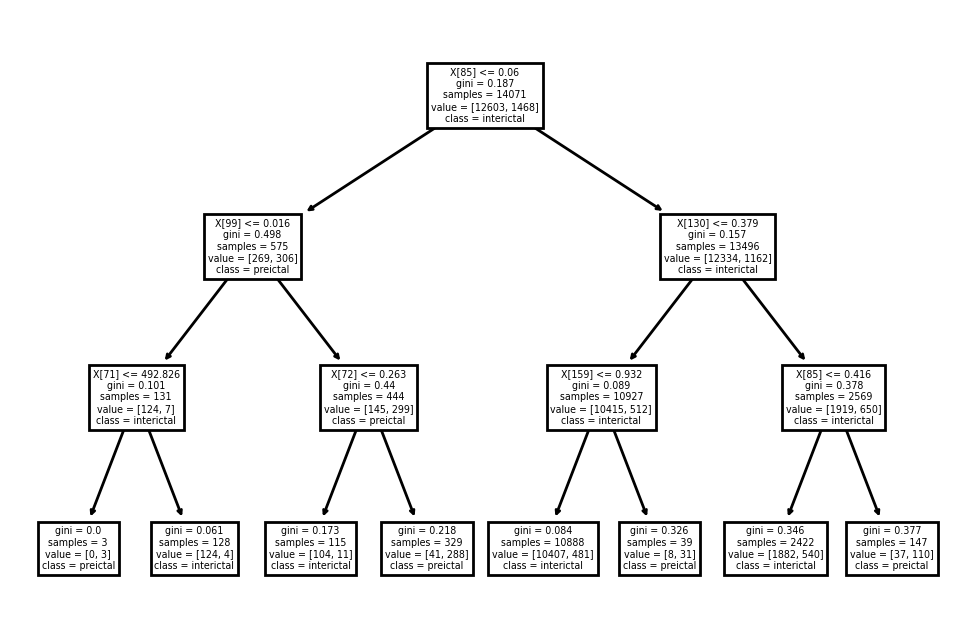

In [226]:
plt.subplots(dpi=200)
tree.plot_tree(clf, class_names=['interictal','preictal'])

In [227]:
y_pred=clf.predict(X_test)

In [228]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, y_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))

TN:1388, FP:13, FN:203, TP:87


In [229]:
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
print('specificity= {} , sensitivity= {}'.format(specificity, sensitivity))

specificity= 0.9907209136331192 , sensitivity= 0.3


In [230]:

print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
print('specificity= {} , sensitivity= {}'.format(specificity, sensitivity))

Training Accuracy: 92%
Testing Accuracy: 87%
TN:1388, FP:13, FN:203, TP:87
specificity= 0.9907209136331192 , sensitivity= 0.3


In [244]:
rf_start = datetime.now()
print(rf_start)


rf = RandomForestClassifier(n_estimators=20, max_depth=400, random_state=70, class_weight='balanced')
rf.fit(X_train, y_train)
trainAcc=rf.score(X_train, y_train)
testAcc=rf.score(X_test, y_test)
print("**Random Forest Results:**")
print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")

rf_finish = datetime.now()
rf_time =(rf_finish-rf_start)
print(rf_time)

2021-05-27 01:08:57.875499
**Random Forest Results:**
Training Accuracy: 99%
Testing Accuracy: 83%
0:00:02.433465


In [245]:
import joblib

    # estimator = joblib.load("/my_models/%s.pkl"%dataset_name)
    # print "using trained model"

# print ("saving new model")
# joblib.dump(clf,"my_models/SVM_blanced_chb04.pkl")

In [246]:
# loaded_clf = joblib.load("my_models/SVM_blanced_chb04.pkl")
# y_pred=loaded_clf.predict(X_test)
rf_y_pred=rf.predict(X_test)

In [247]:
# clf.get_params(deep=True)

In [248]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, rf_y_pred).ravel()
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))

TN:1399, FP:2, FN:273, TP:17


In [249]:
tn

1399

In [250]:
specificity=(tn)/(tn+fp)
sensitivity=(tp)/(tp+fn)
print('specificity= {} , sensitivity= {}'.format(specificity, sensitivity))

specificity= 0.9985724482512491 , sensitivity= 0.05862068965517241


In [251]:
print('X size ={}, y size = {}'.format(X_shape, y_shape))
print('interictal size ={}, preictal size = {}'.format(interictal_shape, preictal_shape))
print('train size ={}, test size = {}'.format(X_train_shape, X_test_shape))

print("Training Accuracy: %d"%(trainAcc*100)+"%")
print("Testing Accuracy: %d"%(testAcc *100)+"%")
print("TN:{}, FP:{}, FN:{}, TP:{}".format(tn, fp, fn, tp))
print('specificity= {} , sensitivity= {}'.format(specificity, sensitivity))

X size =(83290, 208), y size = (83290,)
interictal size =(14004, 210), preictal size = (1468, 210)
train size =(14071, 208), test size = (1691, 208)
Training Accuracy: 99%
Testing Accuracy: 83%
TN:1399, FP:2, FN:273, TP:17
specificity= 0.9985724482512491 , sensitivity= 0.05862068965517241


### grid search

In [252]:
# from numpy import mean
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedStratifiedKFold

In [253]:
# balance = [{0:10,2:1}, {0:1,2:1}, {0:1,2:10}, {0:1,2:50}, {0:1,2:100}]
# costs=[1.0,10.0,100.0]
# param_grid = dict(C=costs, class_weight=balance)

In [254]:
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# grid = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1_weighted')


In [255]:
# grid_result = grid.fit(X_train, y_train)

In [256]:
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))